### Выполнил: Ларченков Артем
### ИСУ: 369936

The lab tasks

0. Q-table
1. Implement simple DQN to solve the problem
  - the solution must have some positive dynamic in terms of the number of successful episodes and steps in episodes. However, the problem can not be completely solved
2. Add experience replay
  - the problem must be solved completely: for the 300 episodes during test the return for each episode must be equal to 200
3. Add target network
  - the problem must be solved completely: for the 300 episodes during test the return for each episode must be equal to 200
4. Implement on-policy method

Soft deadline 27.06
Hard deadline 29.06

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import torch
from torch.autograd import Variable
import random
import math
import torchvision.transforms as T
import numpy as np
import time
from torch import nn
from torch.nn import functional
import gym

from IPython import display
from pyvirtualdisplay import Display
d = Display(visible=0, size=(400, 300))
d.start()

def show_state(env, episode=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


### Simple DQN

In [ ]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion = torch.nn.MSELoss()
            self.model = nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                nn.LeakyReLU(),
                #nn.Linear(hidden_dim, 2*hidden_dim),
                #nn.LeakyReLU(),
                nn.Linear(hidden_dim, action_dim),


            )
            self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=0.9)

            self.losses = []
            self.memory = []

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))

        self.losses.append(loss.detach().numpy())

        # your code here
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


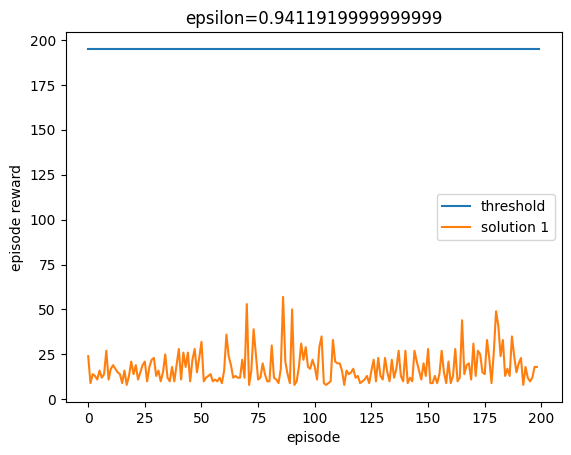

KeyboardInterrupt: ignored

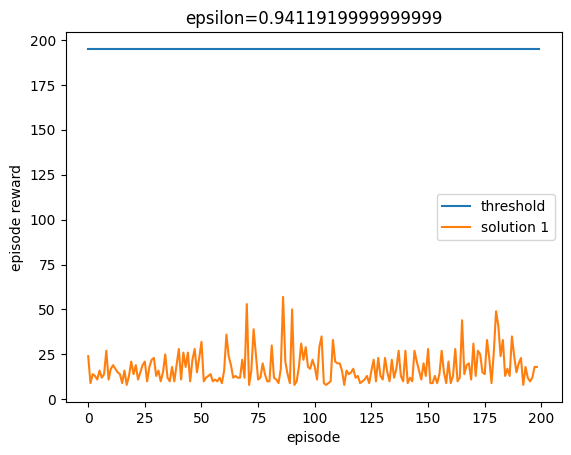

In [ ]:
import gym, math
import numpy as np

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 1 # gready threashold
alpha = 0.2 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = True
EPISODES_MAX = 3000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 16
model = DQN(n_states, n_actions, n_hidden, alpha)

#
memory = []
replay_size = 10

# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation

    if i_episode > 50 and (i_episode + 1) % 50 == 0 and epsilon > 0.01:
        epsilon = epsilon*0.98

    if i_episode > 50 and (i_episode + 1) % 50 == 0:
        plt.figure(2)
        plt.clf()
        # We say that problem is solved, if the mean length of the last 50 episodes it greater th
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        q_values = model.predict(state)

        if np.random.random_sample() < epsilon:
            action = env.action_space.sample()
        else:
          action = torch.argmax(q_values).item()

        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation
        #memory.append((state, action, next_state, reward, done))

        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            q_values[action] = reward
            model.update(state, q_values)
            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break

        observation, reward, done, info = env.step(action)
        rewards += reward
        next_state = observation

        # Update Q-network
        # your code here
        q_values_next = model.predict(next_state)
        q_values[action] = reward + gamma * torch.max(q_values_next).item()
        model.update(state, q_values)


        # Update current state
        state = next_state
    model.scheduler.step()

    #plt.figure(1)
    #plt.clf()
    #plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    #plt.xlabel('step')
    #plt.ylabel('loss')
    #display.clear_output(wait=True)
    #display.display(plt.gcf())


print("done")

### DQN with relays

In [ ]:
class DQN_with_relay():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion = torch.nn.MSELoss()
            self.model = nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                nn.LeakyReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(),
                nn.Linear(hidden_dim, action_dim),

            )
            self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=56, gamma=0.9)

            self.losses = []
            self.memory = []

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))

        self.losses.append(loss.detach().numpy())

        # your code here
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

    def replay(self, size, gamma):
      if len(self.memory) < size:
        return

      batch = random.sample(self.memory, size)
      batch_t = list(map(list, zip(*batch)))

      states = torch.Tensor(batch_t[0])
      actions = torch.LongTensor(batch_t[1])
      next_states = torch.Tensor(batch_t[2])
      rewards = torch.Tensor(batch_t[3])
      is_done = torch.LongTensor(batch_t[4])

      all_q_values = model.predict(states)
      all_q_values_next = model.predict(next_states)
      all_q_values[range(len(all_q_values)), actions] = rewards + gamma*(1-is_done)*torch.max(all_q_values_next, axis=1).values
      self.update(states.tolist(), all_q_values.tolist())





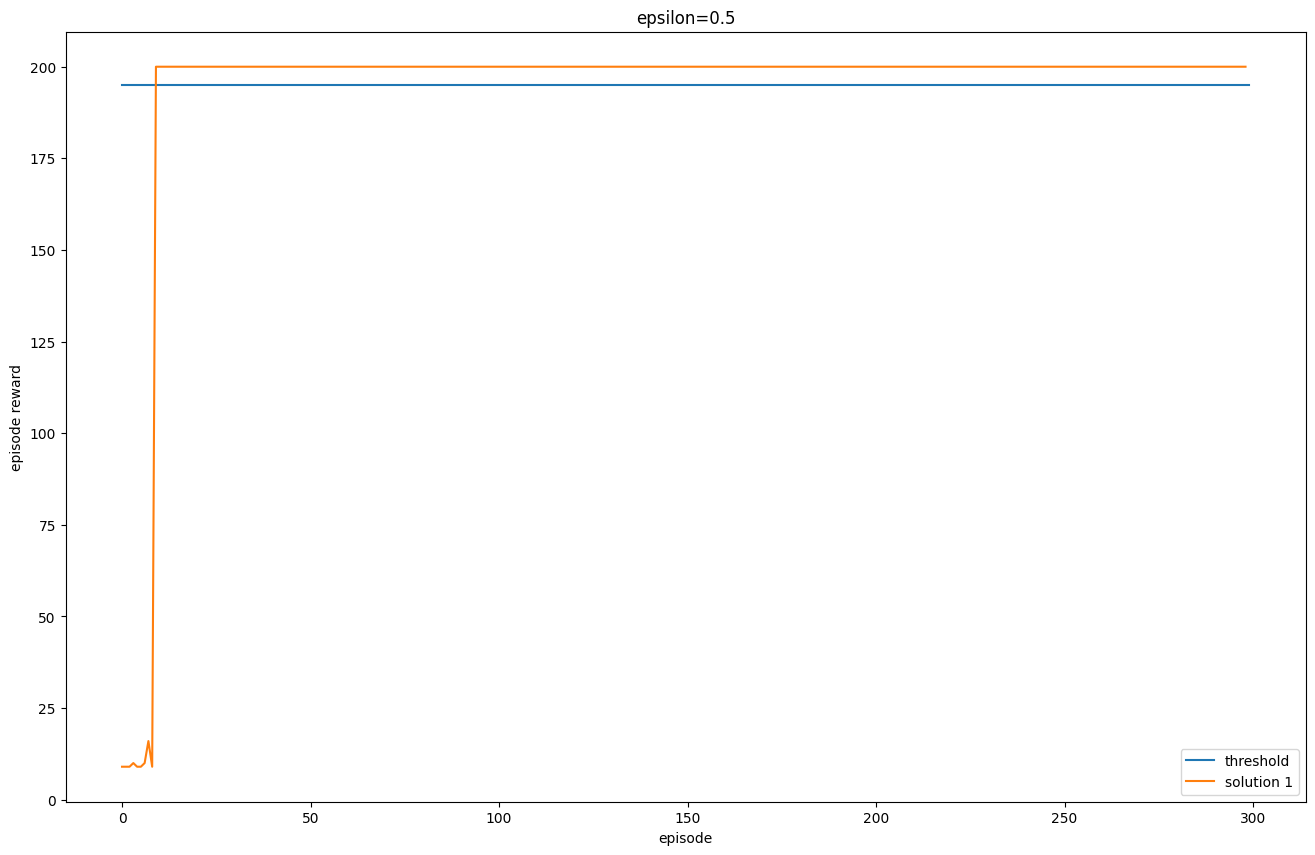

done


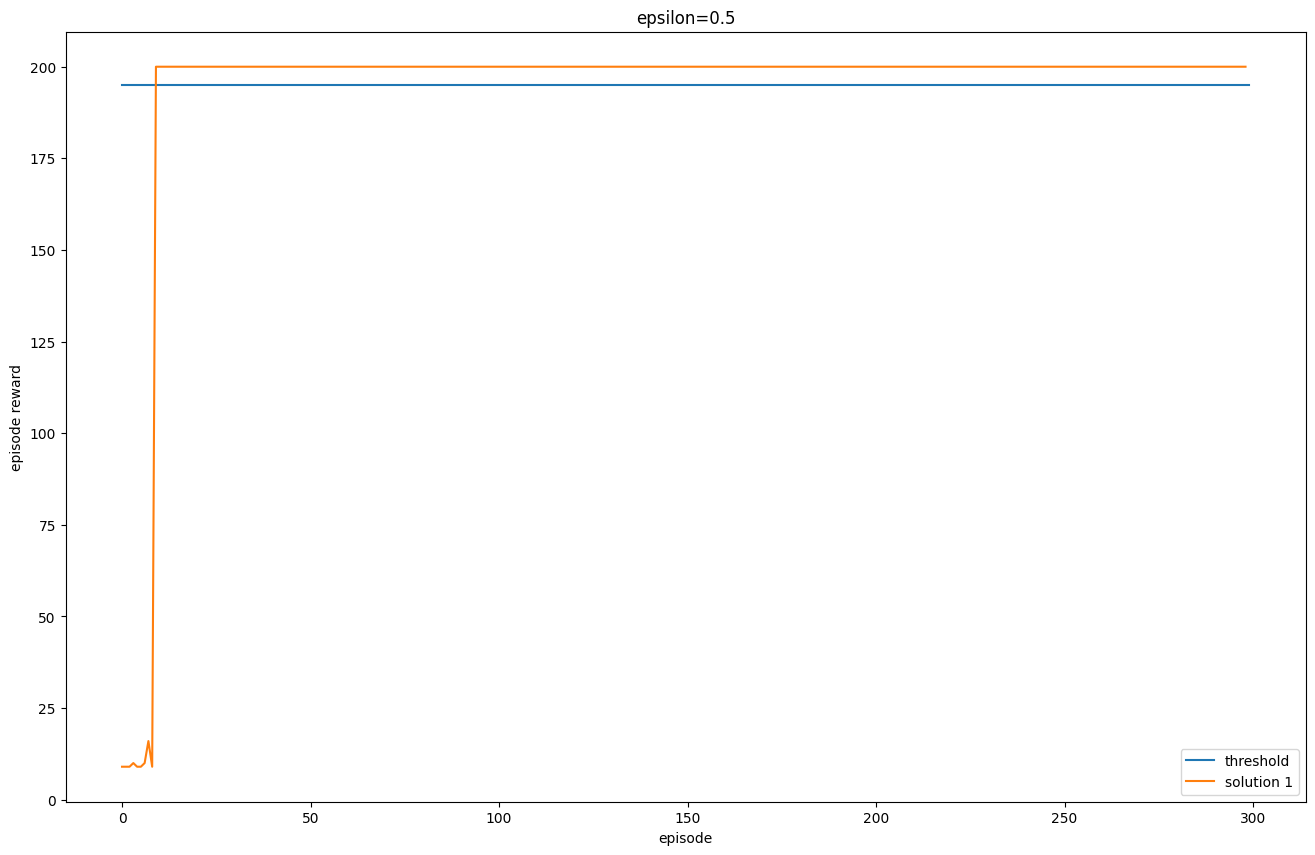

In [ ]:
import gym, math
import numpy as np

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 0.5 # gready threashold
alpha = 0.1 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 300
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)


n_hidden = 16
model_with_relay = DQN_with_relay(n_states, n_actions, n_hidden, alpha)

replay_size = 50
# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation

    if i_episode > 50 and (i_episode + 1) % 50 == 0:
        #epsilon = epsilon*0.8

        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(300):
        q_values = model_with_relay.predict(state)
        action = torch.argmax(q_values).item()# your code here
        observation, reward, done, info = env.step(action)
        rewards += reward
        next_state = observation
        model_with_relay.memory.append((state, action, next_state, reward, done))
        #q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            if len(model_with_relay.memory) < replay_size:
              q_values[action] = reward
              model_with_relay.update(state, q_values)
            else:
              model_with_relay.replay(replay_size, gamma)
            break
        #Update QNN
        if len(model_with_relay.memory) < replay_size:
          q_values_next = model_with_relay.predict(next_state)
          q_values[action] = reward + gamma * torch.max(q_values_next).item()
          model_with_relay.update(state, q_values)
        else:
          model_with_relay.replay(replay_size, gamma)
        state = next_state
    model_with_relay.scheduler.step()

    #plt.figure(1)
    #plt.clf()
    #plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    #plt.xlabel('step')
    #plt.ylabel('loss')
    #display.clear_output(wait=True)
    #display.display(plt.gcf())


print("done")

### DQN with relays and target network

In [ ]:
import copy
class TDQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, dqn):
            self.model = copy.deepcopy(dqn.model)
            self.dqn = dqn

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        parameters = self.dqn.model.state_dict()
        self.model.load_state_dict(parameters)

    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [ ]:
class DQN_with_relay_and_tn():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion = torch.nn.MSELoss()
            self.model = nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                nn.LeakyReLU(),
                #nn.Linear(hidden_dim, 2*hidden_dim),
                #nn.LeakyReLU(),
                nn.Linear(hidden_dim, action_dim),

            )
            self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=56, gamma=0.9)

            self.losses = []
            self.memory = []

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))

        self.losses.append(loss.detach().numpy())

        # your code here
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

    def replay(self, size, gamma):
      if len(self.memory) < size:
        return

      batch = random.sample(self.memory, size)
      batch_t = list(map(list, zip(*batch)))

      states = torch.Tensor(batch_t[0])
      actions = torch.LongTensor(batch_t[1])
      next_states = torch.Tensor(batch_t[2])
      rewards = torch.Tensor(batch_t[3])
      is_done = torch.LongTensor(batch_t[4])

      all_q_values = model.predict(states)
      all_q_values_next = model.predict(next_states)
      all_q_values[range(len(all_q_values)), actions] = rewards + gamma*(1-is_done)*torch.max(all_q_values_next, axis=1).values
      self.update(states.tolist(), all_q_values.tolist())


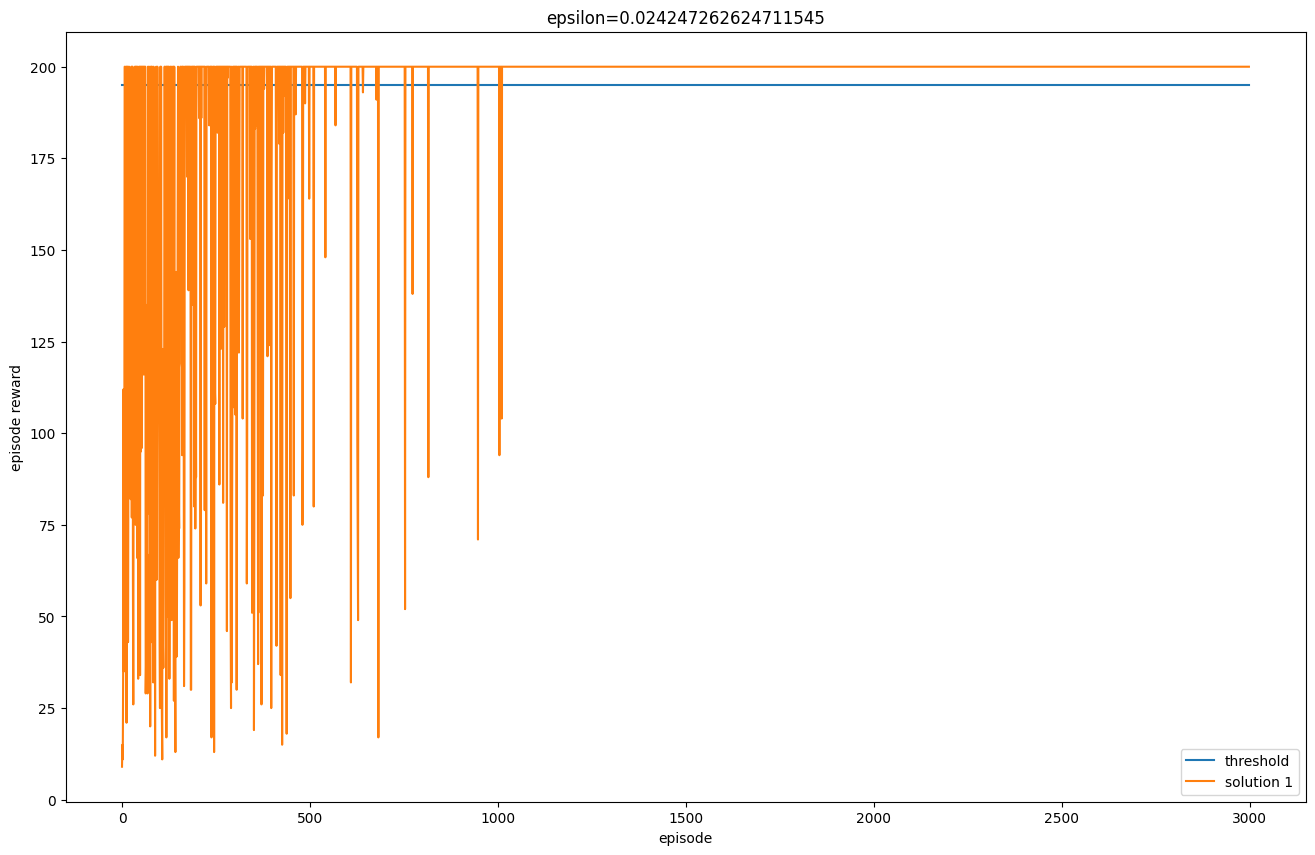

done


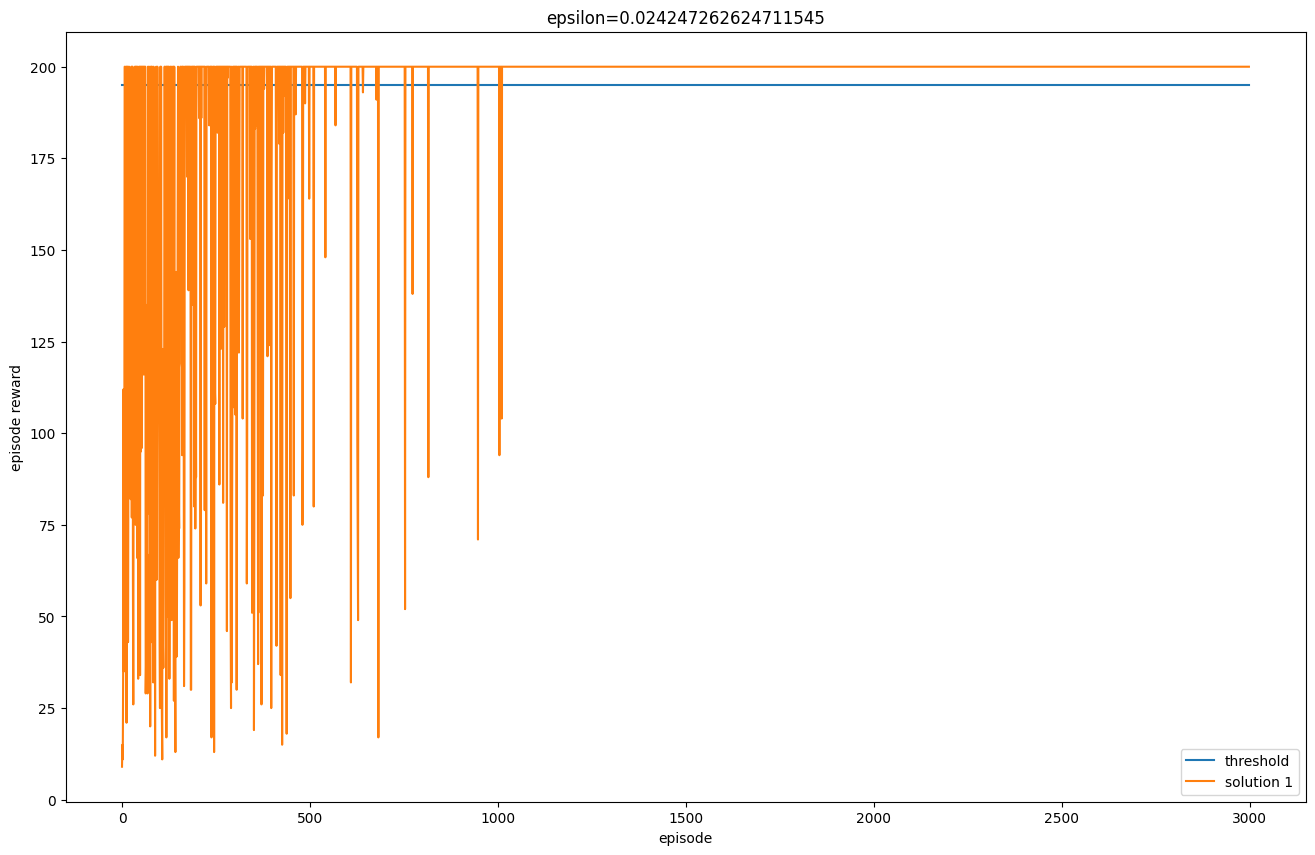

In [ ]:
import gym, math
import numpy as np

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 0.5 # gready threashold
alpha = 0.1   # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 3000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 16
model_with_relay_and_tn = DQN_with_relay_and_tn(n_states, n_actions, n_hidden, alpha)
tmodel = TDQN(model_with_relay_and_tn)

#
replay_size = 50

# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation


    if i_episode > 50 and (i_episode + 1) % 50 == 0 and epsilon > 0.01:
        epsilon = epsilon*0.95

    if (i_episode + 1) % 10 == 0 :
        tmodel.update


    if i_episode > 50 and (i_episode + 1) % 50 == 0 :
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        q_values = model_with_relay_and_tn.predict(state)

        if np.random.random_sample() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q_values).item()# your code here

        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation
        model_with_relay_and_tn.memory.append((state, action, next_state, reward, done))

        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            if len(model_with_relay_and_tn.memory) < replay_size:
              #q_values_next = model.predict(next_state)
              q_values[action] = reward
              model_with_relay_and_tn.update(state, q_values)
            else:
              model_with_relay_and_tn.replay(replay_size, gamma)
            break

        # Update Q-network
        if len(model_with_relay_and_tn.memory) < replay_size:
          q_values_next = model_with_relay_and_tn.predict(next_state)
          q_values[action] = reward + gamma*torch.max(q_values_next).item()
          model_with_relay_and_tn.update(state, q_values)
        else:
          model_with_relay_and_tn.replay(replay_size, gamma)


        # Update current state
        state = next_state
    model_with_relay_and_tn.scheduler.step()

    #plt.figure(1)
    #plt.clf()
    #plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    #plt.xlabel('step')
    #plt.ylabel('loss')
    #display.clear_output(wait=True)
    #display.display(plt.gcf())


print("done")

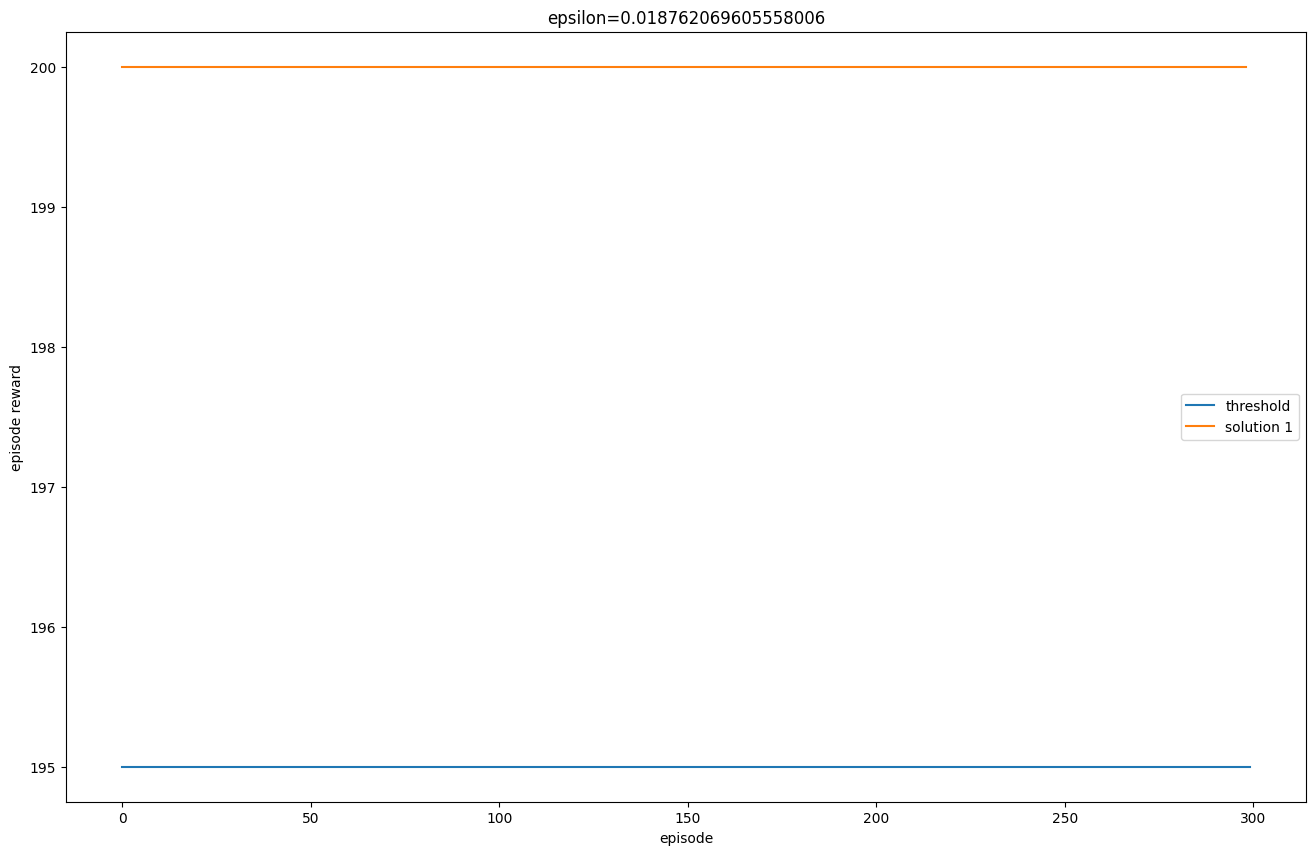

done


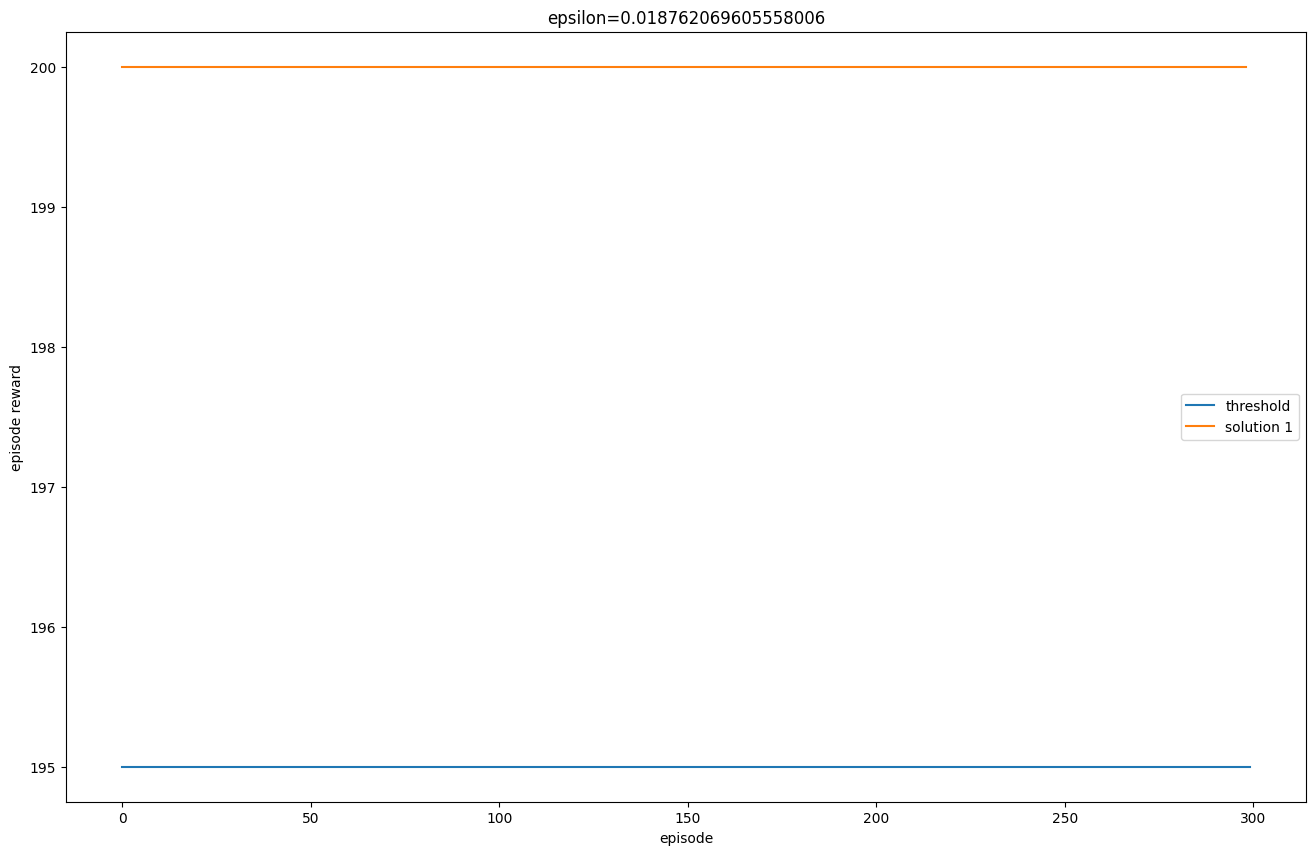

In [ ]:
# Q-learning
for i_episode in range(300):
    observation = env.reset()
    rewards = 0
    state = observation

    if i_episode > 50 and (i_episode + 1) % 50 == 0 :
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(300):
        q_values = model_with_relay_and_tn.predict(state)

        if np.random.random_sample() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q_values).item()# your code here

        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation
        model_with_relay_and_tn.memory.append((state, action, next_state, reward, done))

        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            if len(model_with_relay_and_tn.memory) < replay_size:
              #q_values_next = model.predict(next_state)
              q_values[action] = reward
              model_with_relay_and_tn.update(state, q_values)
            else:
              model_with_relay_and_tn.replay(replay_size, gamma)
            break

        # Update Q-network
        if len(model_with_relay_and_tn.memory) < replay_size:
          q_values_next = model_with_relay_and_tn.predict(next_state)
          q_values[action] = reward + gamma*torch.max(q_values_next).item()
          model_with_relay_and_tn.update(state, q_values)
        else:
          model_with_relay_and_tn.replay(replay_size, gamma)


        # Update current state
        state = next_state
    model_with_relay_and_tn.scheduler.step()

    #plt.figure(1)
    #plt.clf()
    #plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    #plt.xlabel('step')
    #plt.ylabel('loss')
    #display.clear_output(wait=True)
    #display.display(plt.gcf())


print("done")

### DQN with policy gradient

In [ ]:
class PG():
    ''' Policy Gradient class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=16, alpha=0.1):
        self.criterion = torch.nn.MSELoss()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)

    def get_policy(self, state):
        logits = self.model(torch.as_tensor(state, dtype=torch.float32))
        return torch.distributions.Categorical(logits=logits)

    def get_action(self, state):
        policy = self.get_policy(state)
        return policy.sample().item()

    def update(self, batch_states, batch_actions, batch_rewards):
        self.optimizer.zero_grad()
        batch_actions_t = torch.as_tensor(batch_actions, dtype=torch.int64)
        batch_rewards_t = torch.as_tensor(batch_rewards, dtype=torch.float32)
        logp = self.get_policy(batch_states).log_prob(batch_actions_t)
        loss = -(logp * batch_rewards_t).mean()

        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """ Compute action probabilities for all actions using the policy network. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = torch.tensor([0.5, 0.5])  # Example tensor with invalid probabilities
        probs = functional.softmax(probs, dim=0)  # Normalize the tensor to sum to 1
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)


In [ ]:
def reward_to_go(rews):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
    return rtgs

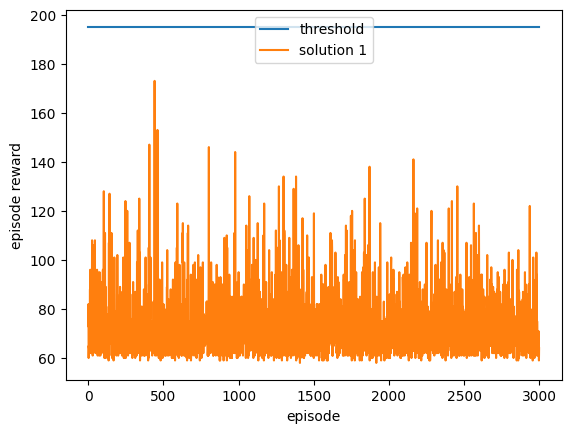

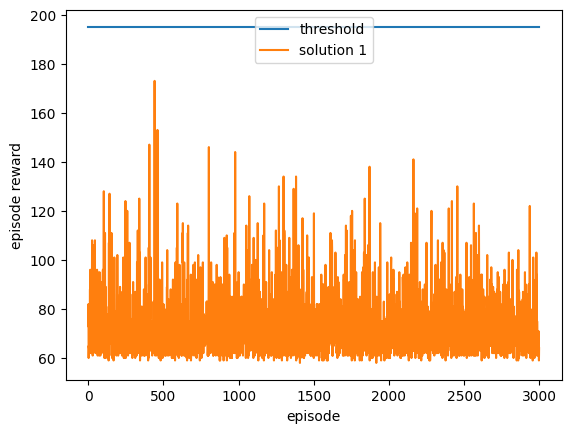

In [ ]:
# Set up the environment and hyperparameters
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 16
alpha = 0.1
num_episodes = 3000
gamma = 0.99

# Create the policy network
policy = PG(state_dim, action_dim, hidden_dim, alpha)
rewards = []
# Train the policy network
for i in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    batch_states = []
    batch_actions = []
    batch_rewards = []
    while not done:
        action, log_prob = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        batch_states.append(state)
        batch_actions.append(action)
        batch_rewards.append(reward)
        episode_reward += reward
        state = next_state
    batch_rewards = reward_to_go(batch_rewards)
    policy.update(batch_states, batch_actions, batch_rewards)
    rewards.append(episode_reward)

plt.figure(2)
plt.clf()
# We say that problem is solved, if the mean length of the last 50 episodes it greater th
plt.plot([0,num_episodes], [195, 195], label="threshold")
plt.plot(rewards, label="solution 1")
plt.xlabel('episode')
plt.ylabel('episode reward')
plt.legend()
display.clear_output(wait=True)
display.display(plt.gcf())